In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tqdm import tqdm

In [3]:
# display iminuit version
import iminuit

# everything in iminuit is done through the Minuit object, so we import it
from iminuit import minimize  # has same interface as scipy.optimize.minimize
from iminuit import Minuit, describe

In [484]:
palette = [
    "#3C38A0",  # deep indigo
#    "#7152B8",  # royal purple (new)
    "#1B7A6E",  # lighter teal
#    "#3A2C20",  # cool dark brown
    "#C26824",  # bright burnt orange
    "#7A014A",  # wine magenta
]

plt.rcParams["axes.prop_cycle"] = plt.cycler(color=palette)

plt.rcParams["font.family"] = "Times New Roman"     # Normal text
plt.rcParams["mathtext.fontset"] = "custom"        # Custom math font
plt.rcParams["mathtext.rm"] = "Times New Roman"    # Roman font for math
plt.rcParams["mathtext.it"] = "Times New Roman:italic"
plt.rcParams["mathtext.bf"] = "Times New Roman:bold"
plt.rcParams["font.size"] = 14

In [4]:
from scipy.interpolate import interp1d

def sample_distribution_given_cdf(x: np.array, cdf: np.array, n_samples: int):
	"""Generate random samples following a particular distribution given
	the CDF.

	Parameters
	----------
	x: numpy array
		Points where the CDF was calculated. `len(x)` must be the same 
		than `len(cdf)`.
	cdf: numpy array
		Value of the CDF at each `x`. `len(x)` must be the same than
		`len(cdf)`.
	n_samples: int
		Number of samples to produce.

	Returns
	-------
	samples: float, numpy array
		Samples produced from the distribution.
	
	Example
	-------
	>>> x_mpv = 0
	>>> xi = 20
	>>> x_axis = np.linspace(x_mpv-5*xi,x_mpv+55*xi,999) # We must be sure to cover the relevant range where the probability is concentrated.
	>>> samples = sample_distribution_given_cdf(x_axis, landau.cdf(x_axis,x_mpv,xi), 99)
	"""
	if any(not isinstance(arg, np.ndarray) for arg in [x, cdf]):
		raise TypeError(f'`x` and `cdf` must be numpy arrays.')
	if not isinstance(n_samples, int):
		raise TypeError(f'`n_samples` must be an integer number.')
	if len(x) != len(cdf):
		raise ValueError(f'`len(x)` must be equal to `len(cdf)`.')
	if n_samples <= 0:
		raise ValueError(f'`n_samples` must be >= 0.')
	inverse_cdf = interp1d(x=cdf, y=x, bounds_error=False)
	samples = np.array([])
	while len(samples)<n_samples:
		samples = np.append(samples, inverse_cdf(np.random.rand(n_samples)))
		samples = samples[~np.isnan(samples)]
	return np.squeeze(samples[:n_samples])

In [5]:
def I(iZ,iPlot=False):
    #https://github.com/nrc-cnrc/EGSnrc/blob/master/HEN_HOUSE/pegs4/pegs4.mortran#L1354-L1391
    lI=[19.2,41.8,40.,63.7,76.0,78.0,82.0,95.0,115.,137.,
     149.,156.,166.,173.,173.,180.,174.,188.,190.,191.,216.,233.,245.,
     257.,272.,286.,297.,311.,322.,330.,334.,350.,347.,348.,357.,352.,
     363.,366.,379.,393.,417.,424.,428.,441.,449.,470.,470.,469.,488.,
     488.,487.,485.,491.,482.,488.,491.,501.,523.,535.,546.,560.,574.,
     580.,591.,614.,628.,650.,658.,674.,684.,694.,705.,718.,727.,736.,
     746.,757.,790.,790.,800.,810.,823.,823.,830.,825.,794.,827.,826.,
     841.,847.,878.,890.,902.,921.,934.,939.,952.,966.,980.,994.]
    lZ=np.arange(1,len(lI)+1)
    if iPlot:
        plt.plot(lZ,lI/lZ)
        plt.xlabel('Z')
        plt.ylabel('I$_{adj}$/Z (eV/Z)')
        plt.show()
    return lI[iZ]*1e-6 #MeV not eV

def A(iZ,iPlot=False):
    #https://github.com/nrc-cnrc/EGSnrc/blob/master/HEN_HOUSE/pegs4/pegs4.mortran#L1354-L1391
    lA=[1.00797,4.0026,6.939,9.0122,10.811,12.01115,14.0067,
     15.9994,18.9984,20.183,22.9898,24.312,26.9815,28.088,30.9738,
     32.064,35.453,39.948,39.102,40.08,44.956,47.90,50.942,51.998,
     54.9380,55.847,58.9332,58.71,63.54,65.37,69.72,72.59,74.9216,
     78.96,79.808,83.80,85.47,87.62,88.905,91.22,92.906,95.94,99.0,
     101.07,102.905,106.4,107.87,112.4,114.82,118.69,121.75,127.60,
     126.9044,131.30,132.905,137.34,138.91,
     140.12,140.907,144.24,147.,150.35,151.98,157.25,158.924,162.50,
     164.930,167.26,168.934,173.04,174.97,178.49,180.948,183.85,
     186.2,190.2,192.2,195.08,196.987,200.59,204.37,207.19,208.980,
     210.,210.,222.,223.,226.,227.,232.036,231.,238.03,237.,242.,
     243.,247.,247.,248.,254.,253.
    ]
    lZ=np.arange(1,len(lA)+1)
    if iPlot:
        plt.plot(lZ,lA/lZ)
        plt.xlabel('Z')
        plt.ylabel('A/Z (Atomic mass/Z)')
        plt.show()
    return lA[iZ-1]

m_e = 0.511
mmuon = 105.4

In [6]:
def gamma(ip,im): #E^2=gamma^2m^2=p^2+m^2
    return np.sqrt(1+(ip/im)**2)

def beta(ip,im): #gamma=1/sqrt(1-b^2)
    g=gamma(ip,im)
    return np.sqrt(1-1./g**2)

def betagamma(ip,im):#p=bgm
    return ip/im

def Tmax(ip,im): # Maximum energy transfer in one collision in MeV
    return 2*m_e*(ip/im)**2/(1+2*gamma(ip,im)*m_e/im+(m_e/im)**2)

def TKinheavy(ip,im): #(T+M)^2=sqrt(p)+sqrt(m)
    return np.sqrt(np.sqrt(ip)+np.sqrt(um))-im

def delta(ip,im):
    C = 4.44
    a = 0.1492
    m = 3.25
    X1 = 2.87
    X0 = 0.2014
    delta0 = 0.14
    x = np.log10(ip/im)
    #f1 = lambda x: delta0 * 10**(2*(x-X0)) # conductors pdg
    f2 = 2 * x * np.log(10) - C + (a * ((X1 - x)**m))
    f3 = 2 * x * np.log(10) - C
    delta_full = np.where(x < X0, 0, f2)
    delta_full = np.where(x < X1 ,delta_full, f3)
    return delta_full

def eToP(iE,im):
    return np.sqrt((iE+im)**2-im**2)

In [7]:
from landaupy import landau

In [8]:
## returns peak val and width
def landauMPV(ip,im,iZ,irho=1,zpart=1):
    K = 0.307075 # constant K in MeV cm mol^-1
    const   = zpart**2 * (K * irho * iZ ) / (2 * A(iZ)) * (1./beta(ip,im)**2)
    #logterm  = 2 * m_e * Tmax(ip,im) * ((ip/im)**2)/(I(iZ)**2)
    logterm1 = 2 * m_e * ((ip/im)**2)/(I(iZ))
    logterm2 = const/I(iZ)
    dEdxV    =  const * (np.log(logterm1) + np.log(logterm2) + 0.2   - (beta(ip,im))**2 - delta(ip,im))       #
    return dEdxV,const

def plotLandau(ip,im,idx,iZ=14,irho=1,zpart=1):
    lP=eToP(ip,im)
    lMPV,lWMPV = landauMPV(lP,im,iZ,irho,zpart)
    lMPV*=idx; lWMPV*=idx
    x=np.arange(0,250,0.01)
    landpy=landau.pdf(x,lMPV,lWMPV)
    return x,landpy

def landauMPV_plastic(ip,im,ZoverA,irho=1,zpart=1):
    K = 0.307075 # constant K in MeV cm mol^-1
    const   = zpart**2 * (K * irho * ZoverA /2)  * (1./beta(ip,im)**2)
    #logterm  = 2 * m_e * Tmax(ip,im) * ((ip/im)**2)/(I(iZ)**2)
    I = 68.7/1e6
    logterm1 = 2 * m_e * ((ip/im)**2)/I
    logterm2 = const/I
    dEdxV    =  const * (np.log(logterm1) + np.log(logterm2) + 0.2  - (beta(ip,im))**2 - delta(ip,im))       #
    return dEdxV,const

def plotLandau_plastic(ip,im,idx,ZoverA,irho=1,zpart=1):
    lP=eToP(ip,im)
    lMPV,lWMPV = landauMPV_plastic(lP,im,ZoverA,irho,zpart)
    lMPV*=idx; lWMPV*=idx
    x=np.arange(0,15.5,0.01)
    landpy=landau.pdf(x,lMPV,lWMPV)
    return x,landpy

In [187]:
def landau_sample(lMPV,lWMPV,n_sample):
    x=np.arange(0,200,1)
    landpy_cdf=landau.cdf(x,lMPV,lWMPV)
    dE = sample_distribution_given_cdf(x, landpy_cdf, n_sample)
    return dE

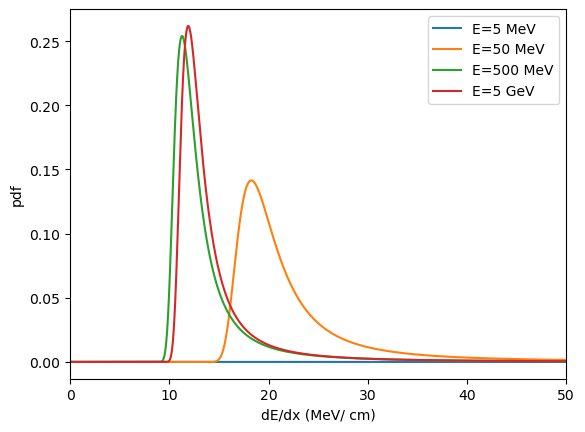

In [232]:
x,landZ5=plotLandau(5,mmuon,1,iZ=82,irho=11.348)
x,landZ50=plotLandau(50,mmuon,1,iZ=82,irho=11.348)
x,landZ500=plotLandau(500,mmuon,1,iZ=82,irho=11.348)
x,landZ5000=plotLandau(5000,mmuon,1,iZ=82,irho=11.348)


plt.plot(x,landZ5,label='E=5 MeV')
plt.plot(x,landZ50,label='E=50 MeV')
plt.plot(x,landZ500,label='E=500 MeV')
plt.plot(x,landZ5000,label='E=5 GeV')
plt.xlabel("dE/dx (MeV/ cm)")
plt.ylabel("pdf")
plt.xlim(0,50)
plt.legend()
plt.show()

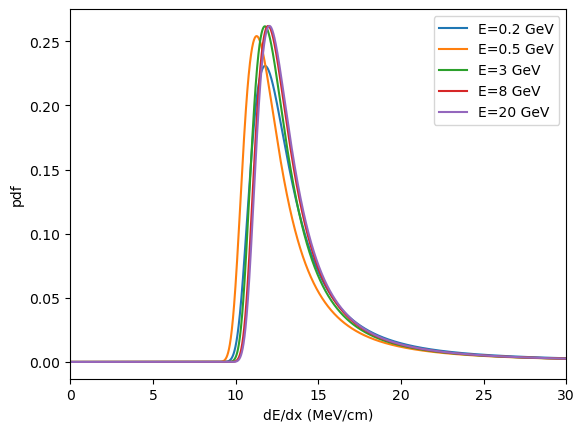

In [189]:
x,landZ050=plotLandau(200,mmuon,1.0,iZ=82,irho=11.348)
x,landZ150=plotLandau(500,mmuon,1.0,iZ=82,irho=11.348)
x,landZ200=plotLandau(3000,mmuon,1.0,iZ=82,irho=11.348)
x,landZ250=plotLandau(8000,mmuon,1.0,iZ=82,irho=11.348)
x,landZ300=plotLandau(20000,mmuon,1.0,iZ=82,irho=11.348)

plt.plot(x,landZ050,label='E=0.2 GeV')
plt.plot(x,landZ150,label='E=0.5 GeV')
plt.plot(x,landZ200,label='E=3 GeV')
plt.plot(x,landZ250,label='E=8 GeV')
plt.plot(x,landZ300,label='E=20 GeV')
plt.xlabel("dE/dx (MeV/cm)")
plt.ylabel("pdf")
plt.xlim(0,30)
plt.legend()
plt.show()

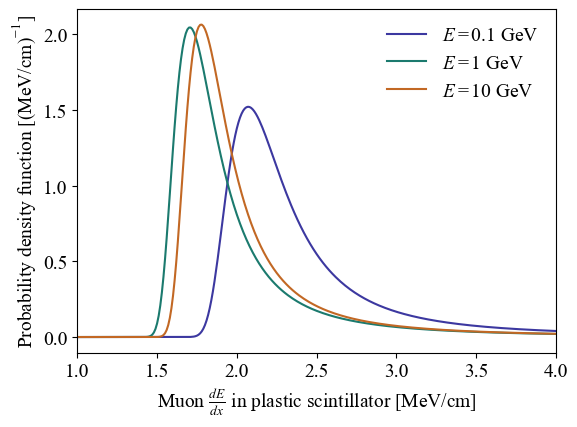

In [584]:
plt.figure(figsize=(6, 4.5))
#x,landZ50=plotLandau_plastic(50,mmuon,1.0,ZoverA=0.53768,irho=1.06)
x,landZ100=plotLandau_plastic(100,mmuon,1.0,ZoverA=0.53768,irho=1.06)
x,landZ1000=plotLandau_plastic(1000,mmuon,1.0,ZoverA=0.53768,irho=1.06)
x,landZ10000=plotLandau_plastic(10000,mmuon,1.0,ZoverA=0.53768,irho=1.06)

#plt.plot(x,landZ50,label=r'$E=0.05 $ GeV')
plt.plot(x,landZ100,label=r'$E=0.1 $ GeV')
plt.plot(x,landZ1000,label=r'$E=1 $ GeV')
plt.plot(x,landZ10000,label=r'$E=10 $ GeV')
plt.xlabel(r"Muon $\frac{dE}{dx}$ in plastic scintillator [MeV/cm]")
plt.ylabel("Probability density function [(MeV/cm)$^{-1}$]")
plt.xlim(1,4)
plt.legend(frameon = False)
plt.tight_layout()
plt.savefig("energy_dep_plastic.pdf")
plt.show()

In [191]:
def simSample(ie=1000,im=mmuon,idt=1e-11,iZ=82, irho=11.348):
    xstep  = np.array([])
    estep  = np.array([])
    pstep  = np.array([])
    c=3e10
    dist=0
    e=ie
    while e>5:
        p = eToP(e,im)
        lMPV,lWMPV  = landauMPV(p,im,iZ=iZ,irho=11.348)
        dE_perdx     = landau_sample(lMPV, lWMPV, 1)
        dx     = beta(p,im)*c*idt#speed of light
        e      -= dE_perdx * dx
        dist   += dx
        xstep  = np.append(xstep,dist)
        estep  = np.append(estep,dE_perdx * dx)
        pstep  = np.append(pstep,e)
    return xstep,pstep,estep

def simSample_fix_x(ie=1000,im=mmuon,idx=1e-2, iZ=82, irho=11.348):
    xstep  = np.array([])
    estep  = np.array([])
    pstep  = np.array([])
    c=3e10
    dist=0
    e=ie
    step = 0

    for step in range(100):
        p = eToP(e,im)
        if e < 5:
            break 
        lMPV,lWMPV  = landauMPV(p,im,iZ=iZ,irho=11.348)
        dE_perdx     = landau_sample(lMPV, lWMPV, 1)
        e      -= dE_perdx * idx
        
        dist   += idx
        xstep  = np.append(xstep,dist)
        estep  = np.append(estep,dE_perdx * idx)
        pstep  = np.append(pstep,e)
        
        step +=1 
    
#        print(e,p)
        
    return xstep,pstep,estep

In [246]:
xstep150,pstep150,estep150 = simSample_fix_x(ie=800,im=mmuon,idx=2e-1,iZ=82,irho=11.348)

In [247]:
xstep150

array([ 0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,  2.2,
        2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,  4.4,
        4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,  6.6,
        6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,  8.8,
        9. ,  9.2,  9.4,  9.6,  9.8, 10. , 10.2, 10.4, 10.6, 10.8, 11. ,
       11.2, 11.4, 11.6, 11.8, 12. , 12.2, 12.4, 12.6, 12.8, 13. , 13.2,
       13.4, 13.6, 13.8, 14. , 14.2, 14.4, 14.6, 14.8, 15. , 15.2, 15.4,
       15.6, 15.8, 16. , 16.2, 16.4, 16.6, 16.8, 17. , 17.2, 17.4, 17.6,
       17.8, 18. , 18.2, 18.4, 18.6, 18.8, 19. , 19.2, 19.4, 19.6, 19.8,
       20. ])

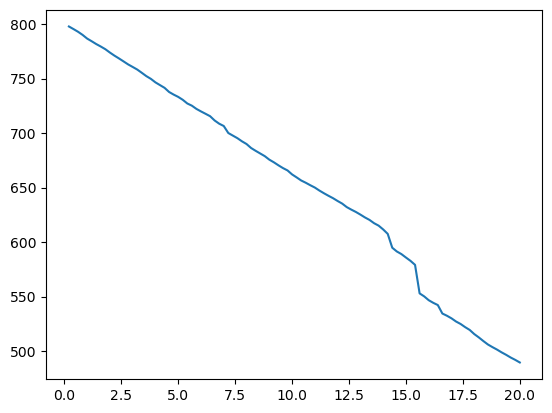

In [248]:
plt.plot(xstep150,pstep150)

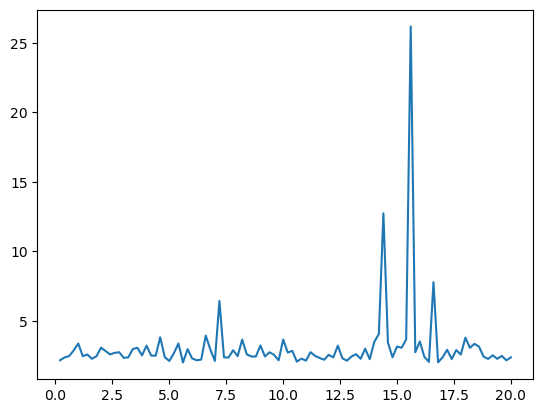

In [249]:
plt.plot(xstep150,estep150)

In [250]:
def powerlaw(E,alpha,Emin=105.7,Emax=10*1000):
    pdf = E**(-alpha)
    norm = ( Emax**(1-alpha) - Emin**(1-alpha) )/( 1-alpha )
    pdf /= norm
    
    cdf = ( E**(1-alpha) - Emin**(1-alpha) )/( Emax**(1-alpha) - Emin**(1-alpha) )
    cdf /= norm

    return pdf, cdf
    


def sample_from_spectrum(alpha, Emin=5, Emax = 10*1000):
    p = np.random.uniform()
    
    a = 1.0 - alpha

    Emin_a = Emin ** a
    Emax_a = Emax ** a

    # Invert CDF:
    #   p = (E^a - Emin^a) / (Emax^a - Emin^a)
    #   => E^a = p*(Emax^a - Emin^a) + Emin^a
    E = (p * (Emax_a - Emin_a) + Emin_a)**(1.0/a)

    # Return sampled E
    return E



In [265]:
def simSample_fix_x_simple(ie=1000,im=mmuon,idx=1e-2, iZ=82, irho=11.348):
    
    dist=0
    e=ie
    step = 0

    for step in range(int(20/idx)):
        p = eToP(e,im)
        if e < 5:
            break 
        lMPV,lWMPV  = landauMPV(p,im,iZ=iZ,irho=11.348)
        dE_perdx     = landau_sample(lMPV, lWMPV, 1)
        e      -= dE_perdx * idx
        dist   += idx
        step +=1 
        
    return dist

In [266]:
def single_muon(alpha):

    ie = sample_from_spectrum(alpha, Emin=5, Emax = 10*1000)
#    print(ie)

    if ie > 800:
        depth = 20
    else:
        depth = simSample_fix_x_simple(ie,im=mmuon,idx=0.25,iZ=82,irho=11.348)

    return depth


In [267]:
counts = 1000

depths = []

for count in tqdm(range(counts)):
    
    depths.append(single_muon(1.1))
    

  0%|                                                  | 0/1000 [00:00<?, ?it/s]/var/folders/rz/wj7nq3j14wx3gj_18_bwmwxm0000gq/T/ipykernel_81675/3897609414.py:33: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((iE+im)**2-im**2)
100%|███████████████████████████████████████| 1000/1000 [02:33<00:00,  6.50it/s]


In [268]:
be = np.array([0,5,10,15,20])
bc = 0.5*(be[1:]+be[:-1])

depths_hist,_ = np.histogram(depths, be)



rel_rates = np.array([
            np.sum(depths_hist), 
            np.sum(depths_hist[1:]), 
            np.sum(depths_hist[2:]), 
            np.sum(depths_hist[3:])
])

In [269]:
rel_rates

array([1000,  505,  420,  383])

In [438]:
def calculate_rel_rates(alpha):
    counts = 25000
    depths = []
    for count in tqdm(range(counts)):
        depths.append(single_muon(alpha))

    be = np.array([0,5,10,15,20])
    bc = 0.5*(be[1:]+be[:-1])
    
    depths_hist,_ = np.histogram(depths, be)
    
    
    
    rel_rates = np.array([
                np.sum(depths_hist), 
                np.sum(depths_hist[1:]), 
                np.sum(depths_hist[2:]), 
                np.sum(depths_hist[3:])
    ])

    return rel_rates 

In [439]:
alphas_new = np.array([0.025*k for k in range(21,36)])
rel_rates_new = []
for alpha in alphas_new:
    rel_rates_new.append(calculate_rel_rates(alpha))

  0%|                                                 | 0/25000 [00:00<?, ?it/s]/var/folders/rz/wj7nq3j14wx3gj_18_bwmwxm0000gq/T/ipykernel_81675/3897609414.py:33: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((iE+im)**2-im**2)
100%|███████████████████████████████████| 25000/25000 [1:17:38<00:00,  5.37it/s]


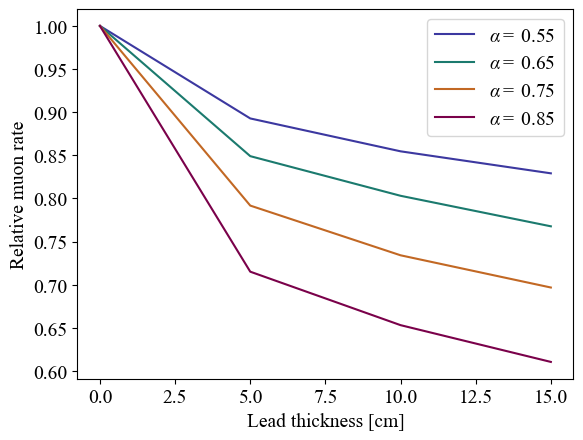

In [578]:
rel_rates_new = np.array(rel_rates_new)

bc = np.array([0,5,10,15])
plt.plot( bc, rel_rates_new[1]/25000, label = r"$\alpha=$"+f"{alphas_new[1]: .2f}")
plt.plot( bc, rel_rates_new[5]/25000, label = r"$\alpha=$"+f"{alphas_new[5]: .2f}")
plt.plot( bc, rel_rates_new[9]/25000, label = r"$\alpha=$"+f"{alphas_new[9]: .2f}")
plt.plot( bc, rel_rates_new[13]/25000, label = r"$\alpha=$"+f"{alphas_new[13]: .2f}")

plt.xlabel("Lead thickness [cm]")
plt.ylabel("Relative muon rate")
plt.legend()

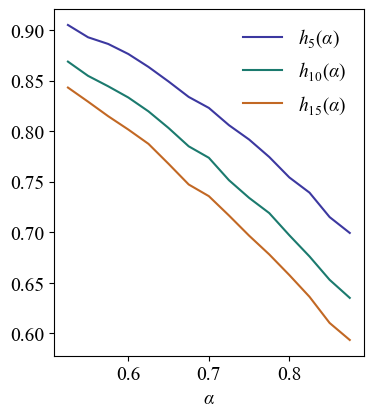

In [551]:
plt.figure(figsize=(4, 4.5))
#plt.plot(alphas_new,rel_rates_new[:,0]/rel_rates_new[:,0], label = r"$h_0 (\alpha)$")
plt.plot(alphas_new,rel_rates_new[:,1]/rel_rates_new[:,0], label = r"$h_5 (\alpha)$")
plt.plot(alphas_new,rel_rates_new[:,2]/rel_rates_new[:,0], label = r"$h_{10} (\alpha)$")
plt.plot(alphas_new,rel_rates_new[:,3]/rel_rates_new[:,0], label = r"$h_{15} (\alpha)$")
plt.xlabel(r"$\alpha$")
plt.legend(frameon = False)
#plt.tight_layout()

plt.savefig('MC_hd.pdf')

In [427]:
from scipy.interpolate import UnivariateSpline

In [443]:
splines_new = []
for j in range(rel_rates_new.shape[1]):
    # s is smoothing. s=0 → exact fit, larger s → smoother
    spl = UnivariateSpline(alphas_new, rel_rates_new[:,j], s=0)
    splines_new.append(spl)

In [444]:
def rates_at(alpha):
    return np.array([spl(alpha) for spl in splines_new])

In [445]:
def powerlaw_model(amp,alpha):
    return amp*rates_at(alpha)/25000

def chi2_power_law(data, data_err, amp, alpha):
    return np.sum((data - powerlaw_model(amp,alpha))**2/data_err**2) 

In [542]:
data = np.array(
    [0.00781921732969893, 0.006539451049978224, 0.006104546751290339, 0.005977048304167995]
)
data_err_stat = np.array(
    [0.00030759457199850104, 0.00014174621854696212, 0.0001291113539456181, 0.00021694550418269398]
)
data_err_sys = 0.025*data

data_err = np.sqrt(data_err_stat**2 + data_err_sys**2)

In [554]:
def chi2(amp, alpha):
    return chi2_power_law(data, data_err, amp, alpha)
    

In [555]:
chi2.errordef = Minuit.LEAST_SQUARES
chi2.ndata = 4

m = Minuit(chi2, amp=0.008, alpha=0.6)
m.migrad()
m.minos()
#m.draw_mnmatrix( )

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.2423 (χ²/ndof = 0.1)     │              Nfcn = 165              │
│ EDM = 4.91e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ amp   │  7.80e-3  │  0.35e-3  │  -0.35e-3  │  0.38e-3   │         │         │       │
│ 1 │ alpha │   0.67    │   0.05    │   -0.06    │    0.06    │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┐
│          │          amp          │         alpha         │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │ -0.35e-3  │  0.38e-3  │   -0.06   │   0.06    │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘
┌───────┬───────────────────┐
│       │      amp    alpha │
├───────┼───────────────────┤
│   amp │ 1.21e-07 17.33e-6 │
│ alpha │ 17.33e-6  0.00302 │
└───────┴───────────────────┘

/var/folders/rz/wj7nq3j14wx3gj_18_bwmwxm0000gq/T/ipykernel_81675/3364472200.py:32: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


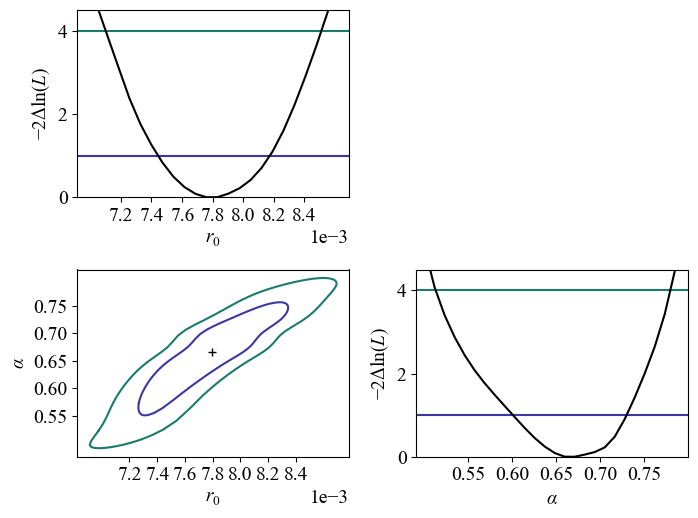

In [588]:
fig, axes = m.draw_mnmatrix(experimental=True, cl=[1,2])   # axes is a 2×2 numpy array of Axes


# Change figure size
fig.set_size_inches(7.2, 5.4)

# Change spacing between subplots
#fig.tight_layout()                 # or:
#fig.subplots_adjust(wspace=0.3, hspace=0.3)

ax00 = axes[0, 0]
ax10 = axes[1, 0]

for ax in (ax00, ax10):
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    ax.xaxis.get_offset_text().set_size(14)   # optional: make offset larger
# Change axis labels
axes[1, 0].set_xlabel(r"$r_0$")
axes[1, 0].set_ylabel(r"$\alpha$")
axes[1, 1].set_xlabel(r"$\alpha$")

axes[0, 0].set_xlabel(r"$r_0$")
axes[0, 0].set_ylabel(r"$-2 \Delta \ln(L)$")
axes[1, 1].set_ylabel(r"$-2 \Delta \ln(L)$")


axes[0,0].set_xticks(np.arange(7.2,8.4,0.2)*1e-3)
axes[1,0].set_xticks(np.arange(7.2,8.4,0.2)*1e-3)

axes[1,1].set_xticks(np.arange(0.55,0.80,0.05))
axes[1,0].set_yticks(np.arange(0.55,0.80,0.05))
fig.tight_layout()         

plt.savefig('contour.pdf')
plt.show()


In [557]:
m

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.2423 (χ²/ndof = 0.1)     │              Nfcn = 165              │
│ EDM = 4.91e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ amp   │  7.80e-3  │  0.35e-3  │  -0.35e-3  │  0.38e-3   │         │         │       │
│ 1 │ alpha │   0.67    │   0.05    │   -0.06    │    0.06    │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┐
│          │          amp          │         alpha         │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │ -0.35e-3  │  0.38e-3  │   -0.06   │   0.06    │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘
┌───────┬───────────────────┐
│       │      amp    alpha │
├───────┼───────────────────┤
│   amp │ 1.21e-07 17.33e-6 │
│ alpha │ 17.33e-6  0.00302 │
└───────┴───────────────────┘

In [558]:
print("amp = ",m.params['amp'].value,r"+/-",m.params['amp'].error)
print("alpha = ",m.params['alpha'].value,r"+/-",m.params['alpha'].error)

amp =  0.007796612012379494 +/- 0.00034799226757443585
alpha =  0.6655241057379783 +/- 0.05491374307020883


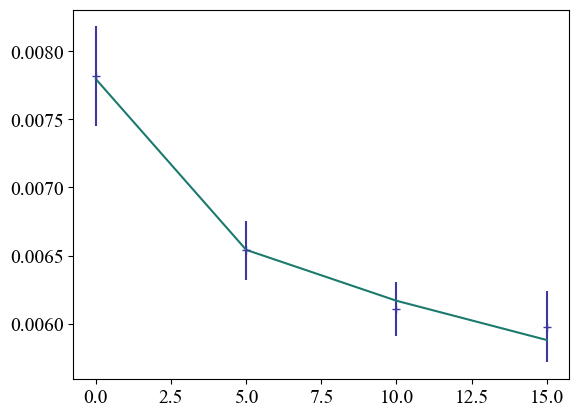

In [559]:
thickness_list = np.array([0,5,10,15])
thickness_fit = np.arange(0,15,0.05)

plt.errorbar(thickness_list,data,data_err, fmt = '+')
plt.plot(thickness_list, m.params['amp'].value*rates_at(m.params['alpha'].value)/25000)

In [453]:
def calculate_rel_rates_for_fit(alpha):
    counts = 25000
    depths = []
    for count in tqdm(range(counts)):
        depths.append(single_muon(alpha))

    be = np.linspace(0,20,20)
    bc = 0.5*(be[1:]+be[:-1])
    
    depths_hist , _ = np.histogram(depths, be)
    
    
    
    rel_rates = np.array([
                np.sum(depths_hist[k:])/counts for k in range(20)
    ])

    return rel_rates 

In [454]:
rel_rates_fit = calculate_rel_rates_for_fit(m.params['alpha'].value)

  0%|                                       | 7/25000 [00:01<1:08:37,  6.07it/s]/var/folders/rz/wj7nq3j14wx3gj_18_bwmwxm0000gq/T/ipykernel_81675/3897609414.py:33: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((iE+im)**2-im**2)
100%|███████████████████████████████████| 25000/25000 [1:09:35<00:00,  5.99it/s]


In [455]:
rel_rates_fit

array([1.     , 0.91892, 0.89124, 0.87368, 0.85936, 0.84472, 0.8346 ,
       0.82372, 0.814  , 0.80592, 0.79608, 0.78908, 0.78268, 0.77544,
       0.77024, 0.76212, 0.75716, 0.752  , 0.7476 , 0.     ])

(-0.5, 15.5)

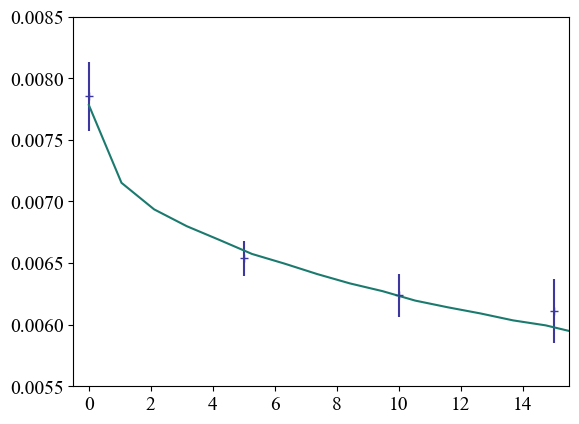

In [456]:
thickness_list = np.array([0,5,10,15])
be = np.linspace(0,20,20)

plt.errorbar(thickness_list,data,data_err, fmt = '+')
plt.plot(be, m.params['amp'].value*rel_rates_fit)
plt.ylim(0.0055, 0.0085)
plt.xlim(-0.5,15.5)

In [548]:
rel_rates_fit_bound1 = calculate_rel_rates_for_fit(0.55)
rel_rates_fit_bound2 = calculate_rel_rates_for_fit(0.75)

  0%|                                       | 2/25000 [00:01<4:22:13,  1.59it/s]/var/folders/rz/wj7nq3j14wx3gj_18_bwmwxm0000gq/T/ipykernel_81675/3897609414.py:33: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((iE+im)**2-im**2)
100%|███████████████████████████████████| 25000/25000 [1:15:08<00:00,  5.54it/s]


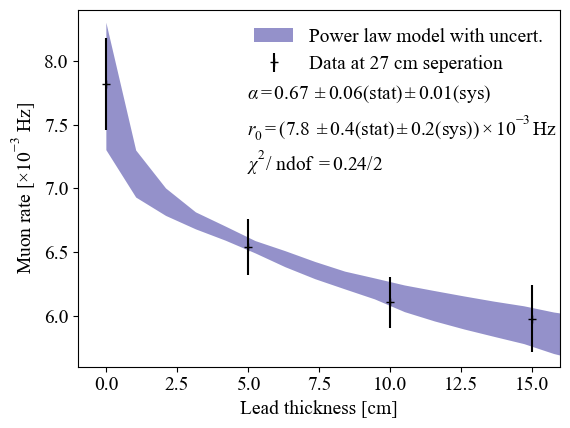

In [586]:
plt.figure(figsize=(6, 4.5))
thickness_list = np.array([0,5,10,15])
be = np.linspace(0,20,20)

data_plot = data*1000
data_err_plot = data_err*1000

plt.errorbar(thickness_list,data_plot,data_err_plot , fmt = 'k+', label = 'Data at 27 cm seperation')

band_top = np.maximum(np.maximum(m.params['amp'].value*rel_rates_fit, 0.0073*rel_rates_fit_bound1) , 0.0083*rel_rates_fit_bound2)*1000
band_bot = np.minimum(np.minimum(m.params['amp'].value*rel_rates_fit, 0.0073*rel_rates_fit_bound1) , 0.0083*rel_rates_fit_bound2)*1000

plt.fill_between(be, band_bot, band_top, alpha = 0.55, label = "Power law model with uncert.")

#plt.plot(be, m.params['amp'].value*rel_rates_fit*1000)

plt.annotate(r"$\alpha = 0.67\; \pm 0.06 (\mathrm{stat}) \pm 0.01 (\mathrm{sys})$" , xy = (0.35,0.75), xycoords="axes fraction")
plt.annotate(r"$r_0 = \left(7.8\; \pm 0.4 (\mathrm{stat}) \pm 0.2 (\mathrm{sys}) \right) \times 10^{-3}\, \mathrm{Hz}$" , xy = (0.35,0.65), xycoords="axes fraction")
plt.annotate(r"$\chi^2$/ ndof $= 0.24/2$" , xy = (0.35,0.55), xycoords="axes fraction")



plt.ylim(5.6, 8.4)
plt.xlim(-1,16)

plt.ylabel(r"Muon rate [$\times 10^{-3}$ Hz]")
plt.xlabel("Lead thickness [cm]")
plt.legend(frameon = False)
plt.tight_layout()
plt.savefig("rates.pdf")

In [561]:
chi2(m.params['amp'].value, m.params['alpha'].value)

np.float64(0.24226653930099978)

In [562]:
print(m.params['alpha'].value, m.params['alpha'].error)


0.6655241057379783 0.05491374307020883
